In [86]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import copy
import matplotlib.pyplot as plt

In [87]:
def get_data():
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    training_data = torchvision.datasets.CIFAR10(root = 'data',
                                               train = True,
                                               transform = transform,
                                               download = True)

    testing_data = torchvision.datasets.CIFAR10(root = 'data',
                                              train = False,
                                              transform = transform,
                                              download=True)
    
    return training_data, testing_data

def get_loaders(training_data, testing_data, batch_size):
    training_loader = torch.utils.data.DataLoader(dataset = training_data,
                                                  batch_size = batch_size,
                                                  shuffle = True)

    testing_loader = torch.utils.data.DataLoader(dataset = testing_data,
                                                 batch_size = batch_size,
                                                 shuffle = True)
    
    return training_loader, testing_loader

In [88]:
def train(model, training_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    num_correct = 0
    for i, data in enumerate(training_loader):
        # TODO: remove this, just here to cut down on running time
        if(i == 50):
            break
        print("Training i:" + str(i))
        data, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, labels)
        running_loss += loss.item()
        _, predictions = torch.max(output.data, 1)
        num_correct += (predictions == labels).sum().item()
        loss.backward()
        optimizer.step()
    
    # TODO: remove this, just here to cut down on running time
    loss = running_loss/(10*50)
    #loss = running_loss/len(training_loader.dataset)
    accuracy = num_correct/ (10*50)
    #accuracy = num_correct/len(training_loader.dataset)
    print(f'Train Loss: {loss:.4f}, Train Acc: {accuracy:.2f}')
    
    return loss, accuracy

def test(model, testing_loader, criterion):
    model.eval()
    running_loss = 0.0
    num_correct = 0
    for i, data in enumerate(testing_loader):
        # TODO: remove this, just here to cut down on running time
        if(i == 10):
            break
        print("Testing i:" + str(i))
        data, labels = data[0].to(device), data[1].to(device)
        output = model(data)
        loss = criterion(output, labels)
        running_loss += loss.item()
        _, predictions = torch.max(output.data, 1)
        num_correct += (predictions == labels).sum().item()
    
    # TODO: remove this, just here to cut down on running time
    loss = running_loss/(10*10)
    #loss = running_loss/len(testing_loader.dataset)
    accuracy = num_correct/(10*10)
    #accuracy = num_correct/len(testing_loader.dataset)
    print(f'Test Loss: {loss:.4f}, Test Acc: {accuracy:.2f}')
    
    return loss, accuracy

def train_and_test(model, training_loader, testing_loader, criterion, optimizer):
    training_historical_loss, training_historical_accuracy = [], []
    testing_historical_loss, testing_historical_accuracy = [], []
    for epoch in range(3):
        print("epoch: " + str(epoch))
        training_loss, training_accuracy = train(model, training_loader, criterion, optimizer)
        testing_loss, testing_accuracy = test(model, testing_loader, criterion)
        training_historical_loss.append(training_loss)
        training_historical_accuracy.append(training_accuracy)
        testing_historical_loss.append(testing_loss)
        testing_historical_loss.append(testing_accuracy)
        
    return  training_historical_loss, testing_historical_loss


In [89]:
def get_weights(model):
    return [param.data for param in model.parameters()]

def get_random_directions(weights, device):
    return [torch.randn(w.size()).to(device) for w in weights]

def normalize_directions(directions, weights):
    for d, w in zip(directions, weights):
        d.mul_(w.norm()/(d.norm() + 1e-10))

In [90]:
def plot_figure(X, Y, Z, title):
    fig = plt.figure(figsize=(10,7.5))
    ax0 = fig.add_subplot(projection='3d' )

    ax0.view_init(elev=30, azim=-20)
    ax0.set_xlabel('X', labelpad=9)
    ax0.set_ylabel('Y', labelpad=-5)
    ax0.set_zlabel("Loss", labelpad=-30)
    ax0.tick_params(axis='x', pad=5, which='major')
    ax0.tick_params(axis='y', pad=-5, which='major')
    ax0.tick_params(axis='z', pad=5, which='major')
    ax0.set_title(title, y=0.85)
    ax0.plot_surface(X, Y, Z, cmap='terrain', antialiased=True, cstride=1, rstride=1, alpha=0.75)

    plt.show()

In [91]:
def get_random_direction_losses(model, testing_loader, criterion, device):
    
    weights = get_weights(model)

    random_x_directions = get_random_directions(weights, device);
    random_y_directions = get_random_directions(weights, device);

    normalize_directions(random_x_directions, weights);
    normalize_directions(random_y_directions, weights);

    x_coordinates = np.arange(-0.1, 0.125, 0.025)   
    y_coordinates = np.arange(-0.1, 0.125, 0.025)  
    X, Y = np.meshgrid(x_coordinates, y_coordinates)
    Z = np.zeros((x_coordinates.size, y_coordinates.size))

    for y_index, y in enumerate(y_coordinates):
        for x_index, x in enumerate(x_coordinates):
        
            print("X: " + str(x))
            print("Y: " + str(y))
        
            updated_x_directions = [direction * x for direction in random_x_directions]
            updated_y_directions = [direction * y for direction in random_y_directions]
            delta = [sum(direction) for direction in zip(updated_x_directions, updated_y_directions)]
            old_weights = copy.deepcopy(get_weights(model))
        
            for (p, w, d) in zip(model.parameters(), old_weights, delta):
                p.data = w + torch.Tensor(d).type(type(w)).to(device)
            
            testing_loss, testing_accuracy = test(model, testing_loader, criterion)
            Z[y_index][x_index] = testing_loss
        
            for (p, w) in zip(model.parameters(), old_weights):
                p.data = w
                
    return X, Y, Z

In [92]:
def create_loss_landscape(model, training_loader, testing_loader, device, graph_title):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    training_historical_loss, testing_historical_loss = train_and_test(model, training_loader, testing_loader, criterion, optimizer)
    X, Y, Z = get_random_direction_losses(model, testing_loader, criterion, device)
    plot_figure(X, Y, Z, graph_title)

In [93]:
def create_VGG_loss_landscape(training_loader, testing_loader, device):
    vgg11 = models.vgg11(weights = models.VGG11_Weights.DEFAULT)
    
    # change the number of classes 
    vgg11.classifier[6].out_features = 10
    
    create_loss_landscape(vgg11, training_loader, testing_loader, device, 'YGG Random Directions')

In [94]:
def create_ResNet_loss_landscape(training_loader, testing_loader, device):
    resnet50 = models.resnet50(weights = models.ResNet50_Weights.DEFAULT)

    # change the number of classes 
    resnet50.fc.out_features = 10
    
    create_loss_landscape(resnet50, training_loader, testing_loader, device, 'ResNet Random Directions')

# Orchestration

Files already downloaded and verified
Files already downloaded and verified
epoch: 0
Training i:0
Training i:1
Training i:2
Training i:3
Training i:4
Training i:5
Training i:6
Training i:7
Training i:8
Training i:9
Training i:10
Training i:11
Training i:12
Training i:13
Training i:14
Training i:15
Training i:16
Training i:17
Training i:18
Training i:19
Training i:20
Training i:21
Training i:22
Training i:23
Training i:24
Training i:25
Training i:26
Training i:27
Training i:28
Training i:29
Training i:30
Training i:31
Training i:32
Training i:33
Training i:34
Training i:35
Training i:36
Training i:37
Training i:38
Training i:39
Training i:40
Training i:41
Training i:42
Training i:43
Training i:44
Training i:45
Training i:46
Training i:47
Training i:48
Training i:49
Train Loss: 0.6087, Train Acc: 0.05
Testing i:0
Testing i:1
Testing i:2
Testing i:3
Testing i:4
Testing i:5
Testing i:6
Testing i:7
Testing i:8
Testing i:9
Test Loss: 0.4600, Test Acc: 0.13
epoch: 1
Training i:0
Training i:1


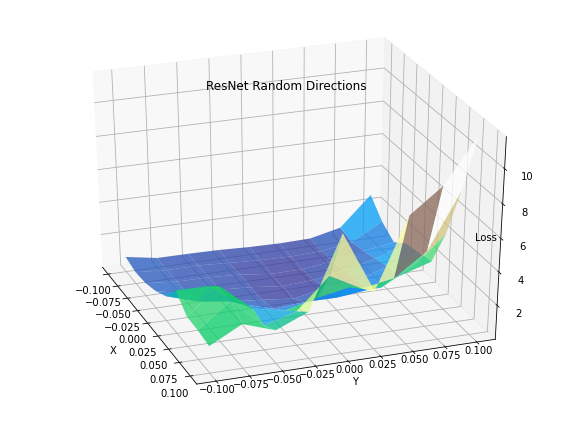

Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

epoch: 0
Training i:0
Training i:1
Training i:2
Training i:3
Training i:4
Training i:5
Training i:6
Training i:7
Training i:8
Training i:9
Training i:10
Training i:11
Training i:12
Training i:13
Training i:14
Training i:15
Training i:16
Training i:17
Training i:18
Training i:19
Training i:20
Training i:21
Training i:22
Training i:23
Training i:24
Training i:25
Training i:26
Training i:27
Training i:28
Training i:29
Training i:30
Training i:31
Training i:32
Training i:33
Training i:34
Training i:35
Training i:36
Training i:37
Training i:38
Training i:39
Training i:40
Training i:41
Training i:42
Training i:43
Training i:44
Training i:45
Training i:46
Training i:47
Training i:48
Training i:49
Train Loss: 0.3874, Train Acc: 0.11
Testing i:0
Testing i:1
Testing i:2
Testing i:3
Testing i:4
Testing i:5
Testing i:6
Testing i:7
Testing i:8
Testing i:9
Test Loss: 0.2362, Test Acc: 0.10
epoch: 1
Training i:0
Training i:1
Training i:2
Training i:3
Training i:4
Training i:5
Training i:6
Training i:

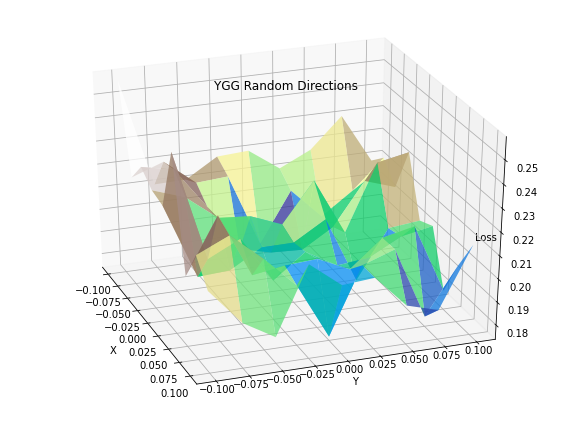

In [95]:
training_data, testing_data = get_data()
training_loader, testing_loader = get_loaders(training_data, testing_data, 10)
classes = training_data.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

create_ResNet_loss_landscape(training_loader, testing_loader, device)
create_VGG_loss_landscape(training_loader, testing_loader, device)